In [1]:
!pip install numpy torch librosa scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [7]:
!pip install soundfile

In [25]:
import os

# --- THIS IS THE PATH YOU NEED TO CHECK ---
path_to_check = "/kaggle/input/librispeech-clean/LibriSpeech/train-clean-100"
# Make sure "/kaggle/input/librispeech-clean" is the correct input directory for your LibriSpeech dataset on Kaggle.
# You can see your input directories by looking at the "Data" panel on the right of your Kaggle notebook.

if os.path.exists(path_to_check):
    print(f"Path exists: {path_to_check}")
    speaker_folders = [d for d in os.listdir(path_to_check) if os.path.isdir(os.path.join(path_to_check, d))]
    print(f"Number of speaker folders found directly under this path: {len(speaker_folders)}")
    if len(speaker_folders) > 0:
        print("First 10 speaker folders found:", sorted(speaker_folders)[:10])
    if len(speaker_folders) < 200:
        print("WARNING: Fewer than 200 speaker folders found. This path might be incorrect or the dataset incomplete for train-clean-100.")
        print("Ensure this path directly contains the numbered speaker ID folders (e.g., '19', '26', '103', ...).")
        print("\nFull listing of items in this path (first 20):")
        for item in sorted(os.listdir(path_to_check))[:20]:
            print(f"- {item}")
    else:
        print(f"This looks promising for train-clean-100 (found {len(speaker_folders)} speaker folders).")

else:
    print(f"PATH NOT FOUND: {path_to_check}")
    print("Please verify LIBRISPEECH_DATASET_PATH and the internal structure of your LibriSpeech Kaggle dataset.")
    print("The LIBRISPEECH_TRAIN_PATH should point to the directory that *contains* the speaker ID folders (e.g., 19, 26, 103...).")

Path exists: /kaggle/input/librispeech-clean/LibriSpeech/train-clean-100
Number of speaker folders found directly under this path: 251
First 10 speaker folders found: ['103', '1034', '1040', '1069', '1081', '1088', '1098', '1116', '118', '1183']
This looks promising for train-clean-100 (found 251 speaker folders).


In [26]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import librosa
from sklearn.metrics import roc_curve # For EER
from tqdm import tqdm
import glob
import random


# LibriSpeech Paths
LIBRISPEECH_DATASET_PATH = "/kaggle/input/librispeech-clean" 
LIBRISPEECH_TRAIN_PATH = os.path.join(LIBRISPEECH_DATASET_PATH, "LibriSpeech/train-clean-100")
LIBRISPEECH_DEV_PATH = os.path.join(LIBRISPEECH_DATASET_PATH, "LibriSpeech/dev-clean") 

# Audio & Feature Parameters
SAMPLE_RATE = 16000
N_MELS = 80
FRAME_LENGTH = 0.025
FRAME_STRIDE = 0.01
MAX_FRAMES = 200

# Speaker Model & Training Parameters
ADAPTIVE_POOL_OUTPUT_SIZE_SPEAKER = (1,1)
SPEAKER_EMBEDDING_DIM = 256
SPEAKER_INITIAL_FILTERS = 64

BATCH_SIZE = 32
EPOCHS = 12 
SPEAKER_LEARNING_RATE = 0.0005
WEIGHT_DECAY_SPEAKER = 1e-4
SPEAKER_FC_DROPOUT_RATE = 0.4


LR_SCHEDULER_TYPE = "StepLR"
LR_STEP_SIZE = 10 
LR_GAMMA = 0.5

GRAD_CLIP_VALUE_SPEAKER = 1.0

# EER Evaluation Parameters
NUM_EER_EVAL_PAIRS = 2000 
EER_EVAL_EPOCH_INTERVAL = 1 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Feature Extraction (Static Method) ---
def extract_features_static(waveform, sr, max_frames=MAX_FRAMES, n_mels=N_MELS):
    if sr != SAMPLE_RATE:
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=SAMPLE_RATE)
    mel_spec = librosa.feature.melspectrogram(
        y=waveform, sr=SAMPLE_RATE, n_fft=int(SAMPLE_RATE * FRAME_LENGTH),
        hop_length=int(SAMPLE_RATE * FRAME_STRIDE), n_mels=n_mels, power=2.0
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    delta1 = librosa.feature.delta(mel_spec_db, order=1)
    delta2 = librosa.feature.delta(mel_spec_db, order=2)
    features = np.stack([mel_spec_db, delta1, delta2], axis=0)
    current_frames = features.shape[2]
    if current_frames > max_frames:
        features = features[:, :, :max_frames]
    else:
        pad_width = max_frames - current_frames
        features = np.pad(features, ((0, 0), (0, 0), (0, pad_width)), mode='constant')
    features_tensor = torch.tensor(features, dtype=torch.float32)
    mean = features_tensor.mean(dim=(1, 2), keepdim=True)
    std = features_tensor.std(dim=(1, 2), keepdim=True)
    return (features_tensor - mean) / (std + 1e-9)

# --- LibriSpeech Dataset Class (for Speaker Model) ---
class LibriSpeechSpeakerDataset(Dataset):
    def __init__(self, root_dir, cache_features=True, max_frames=MAX_FRAMES, n_mels=N_MELS):
        self.root_dir = root_dir
        self.data = []
        self.speaker_to_idx = {} 
        self.idx_to_speaker = {}
        self.idx_counter = 0
        self.cache_features = cache_features
        self.feature_cache = {}
        self.max_frames = max_frames
        self.n_mels = n_mels
        self.speaker_files_map = {} 
        if not os.path.exists(root_dir):
            raise FileNotFoundError(f"Dataset root directory not found: {root_dir}")

        speaker_ids_str = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        print(f"Found {len(speaker_ids_str)} potential speaker directories in {root_dir}")

        for speaker_id_str in tqdm(speaker_ids_str, desc=f"Processing speakers in {os.path.basename(root_dir)}"):
            if speaker_id_str not in self.speaker_to_idx:
                self.speaker_to_idx[speaker_id_str] = self.idx_counter
                self.idx_to_speaker[self.idx_counter] = speaker_id_str
                self.speaker_files_map[self.idx_counter] = []
                self.idx_counter += 1
            
            speaker_label_int = self.speaker_to_idx[speaker_id_str]
            
            speaker_audio_files_pattern = os.path.join(root_dir, speaker_id_str, "*", "*.flac")
            for audio_file_path in glob.glob(speaker_audio_files_pattern):
                self.data.append({
                    "audio_path": audio_file_path,
                    "speaker_label": speaker_label_int,
                })
                self.speaker_files_map[speaker_label_int].append(audio_file_path)
        
        self.num_unique_speakers = len(self.speaker_to_idx)
        if not self.data:
            raise RuntimeError(f"No audio files found. Check root_dir and dataset structure: {root_dir}")
        print(f"LibriSpeechSpeakerDataset: Loaded {len(self.data)} audio files for {self.num_unique_speakers} unique speakers from {root_dir}.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        audio_file = entry["audio_path"]
        speaker_label = entry["speaker_label"]
        
        if self.cache_features and audio_file in self.feature_cache:
            features = self.feature_cache[audio_file]
        else:
            try:
                waveform, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
                features = extract_features_static(waveform, sr, max_frames=self.max_frames, n_mels=self.n_mels)
                if self.cache_features: self.feature_cache[audio_file] = features
            except Exception as e:
                print(f"Error processing {audio_file} (LibriSpeech): {e}. Returning zero tensor.")
                features = torch.zeros((3, self.n_mels, self.max_frames), dtype=torch.float32)
        return features, speaker_label

# SpeakerResNet Model  
def conv3x3(in_planes, out_planes, stride=1): return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
def conv1x1(in_planes, out_planes, stride=1): return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__(); self.conv1 = conv3x3(inplanes, planes, stride); self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True); self.conv2 = conv3x3(planes, planes); self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample; self.stride = stride
    def forward(self, x):
        identity = x; out = self.relu(self.bn1(self.conv1(x))); out = self.bn2(self.conv2(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity; return self.relu(out)

class SpeakerResNetRefined(nn.Module):
    def __init__(self, block, layers, num_speakers, embedding_dim=SPEAKER_EMBEDDING_DIM, initial_filters=SPEAKER_INITIAL_FILTERS):
        super(SpeakerResNetRefined, self).__init__()
        self.inplanes = initial_filters
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=(1, 2), padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes); self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2,2), padding=1)
        self.layer1 = self._make_layer(block, initial_filters, layers[0])
        self.layer2 = self._make_layer(block, initial_filters*2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, initial_filters*4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, initial_filters*8, layers[3], stride=(1,2))
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
        fc_input_features = initial_filters*8 * block.expansion
        self.fc_embedding_proj = nn.Linear(fc_input_features, embedding_dim)
        self.bn_embedding = nn.BatchNorm1d(embedding_dim)
        self.relu_embedding = nn.ReLU(inplace=True)
        self.dropout_classifier = nn.Dropout(SPEAKER_FC_DROPOUT_RATE)
        self.fc_classifier = nn.Linear(embedding_dim, num_speakers)
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)): nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear): nn.init.xavier_normal_(m.weight);
            if hasattr(m, 'bias') and m.bias is not None: nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride), nn.BatchNorm2d(planes * block.expansion))
        layers_made = [block(self.inplanes, planes, stride, downsample)]; self.inplanes = planes * block.expansion
        for _ in range(1, blocks): layers_made.append(block(self.inplanes, planes))
        return nn.Sequential(*layers_made)
    def forward(self, x, return_embedding=False):
        x = self.relu(self.bn1(self.conv1(x))); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.adaptive_pool(x); x = torch.flatten(x, 1)
        embedding = self.fc_embedding_proj(x); embedding = self.bn_embedding(embedding); embedding_activated = self.relu_embedding(embedding)
        if return_embedding: return embedding_activated
        output = self.fc_classifier(self.dropout_classifier(embedding_activated))
        return output

def GetResNet18(num_speakers, embedding_dim=SPEAKER_EMBEDDING_DIM):
    return SpeakerResNetRefined(BasicBlock, [2, 2, 2, 2], num_speakers, embedding_dim)

# Collate Function for Speaker Data 
def collate_fn_speaker(batch):
    features, speaker_labels = zip(*batch)
    features = torch.stack(features); speaker_labels = torch.tensor(speaker_labels, dtype=torch.long)
    return features, speaker_labels

# Training Function for Speaker Model
def train_speaker_model(model, train_loader, criterion, optimizer, grad_clip_value=None):
    model.train()
    running_loss, correct_predictions, total_samples = 0.0, 0, 0
    progress_bar = tqdm(train_loader, desc="Training Speaker Model", leave=False)
    for features, labels in progress_bar:
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad(); outputs = model(features); loss = criterion(outputs, labels)
        loss.backward()
        if grad_clip_value: torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)
        optimizer.step()
        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0); correct_predictions += (predicted == labels).sum().item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{(predicted == labels).sum().item() / labels.size(0):.3f}"})
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

# EER Evaluation Functions
def generate_verification_pairs(dataset_speaker_files_map, num_target_pairs, num_imposter_pairs):
    pairs = []; labels = []
    valid_speakers_for_pairs = {spk_label: files for spk_label, files in dataset_speaker_files_map.items() if len(files) >= 2}
    speaker_list = list(valid_speakers_for_pairs.keys())

    if len(speaker_list) < 2:
        print("WARNING: EER: Need at least 2 speakers with >=2 utterances each for pair generation.")
        return [], []

   
    target_generated = 0
    attempts = 0
    max_attempts_factor = 5 
    
    while target_generated < num_target_pairs and attempts < num_target_pairs * max_attempts_factor:
        attempts += 1
        spk_label = random.choice(speaker_list)
        if len(valid_speakers_for_pairs[spk_label]) < 2: continue 
        f1, f2 = random.sample(valid_speakers_for_pairs[spk_label], 2)
        
        pairs.append((f1, f2)); labels.append(1); target_generated += 1
    print(f"EER: Generated {target_generated} target pairs.")

   
    imposter_generated = 0
    attempts = 0
   
    while imposter_generated < num_imposter_pairs and attempts < num_imposter_pairs * max_attempts_factor:
        attempts += 1
        spk1_label, spk2_label = random.sample(speaker_list, 2)
        if spk1_label == spk2_label: continue # Ensure different speakers
        if not valid_speakers_for_pairs[spk1_label] or not valid_speakers_for_pairs[spk2_label]: continue

        f1 = random.choice(valid_speakers_for_pairs[spk1_label])
        f2 = random.choice(valid_speakers_for_pairs[spk2_label])
        pairs.append((f1, f2)); labels.append(0); imposter_generated += 1
    print(f"EER: Generated {imposter_generated} imposter pairs.")
    
    if not pairs: print("WARNING: EER: No verification pairs were generated.")
    return pairs, labels

embedding_cache_eer = {} 

def evaluate_eer(model, dataset_for_eer_pairs, num_pairs_total=NUM_EER_EVAL_PAIRS):
    model.eval()
    embedding_cache_eer.clear() 

    num_target = num_pairs_total // 2
    num_imposter = num_pairs_total - num_target
    
    
    trial_pairs, trial_labels = generate_verification_pairs(dataset_for_eer_pairs.speaker_files_map, num_target, num_imposter)

    if not trial_pairs: return float('nan')

    scores = []
    valid_labels_for_scores = []

   
    for i, (f1_path, f2_path) in enumerate(tqdm(trial_pairs, desc="EER Pair Scoring", leave=False)):
        emb1, emb2 = None, None
        try:
            if f1_path not in embedding_cache_eer:
                wf1, sr1 = librosa.load(f1_path, sr=SAMPLE_RATE)
                feat1 = extract_features_static(wf1, sr1).unsqueeze(0).to(DEVICE)
                with torch.no_grad(): embedding_cache_eer[f1_path] = model(feat1, return_embedding=True).squeeze(0).cpu()
            emb1 = embedding_cache_eer[f1_path]

            if f2_path not in embedding_cache_eer:
                wf2, sr2 = librosa.load(f2_path, sr=SAMPLE_RATE)
                feat2 = extract_features_static(wf2, sr2).unsqueeze(0).to(DEVICE)
                with torch.no_grad(): embedding_cache_eer[f2_path] = model(feat2, return_embedding=True).squeeze(0).cpu()
            emb2 = embedding_cache_eer[f2_path]
            
            if emb1 is not None and emb2 is not None:
                similarity = torch.nn.functional.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
                scores.append(similarity)
                valid_labels_for_scores.append(trial_labels[i]) # Only add label if score was computed
           
        except Exception as e:
            print(f"EER: Error processing pair ({os.path.basename(f1_path)}, {os.path.basename(f2_path)}): {e}")

    if not scores or len(np.unique(valid_labels_for_scores)) < 2:
        print("EER WARNING: Not enough valid scores or only one class in labels for EER calculation.")
        return float('nan')

    fpr, tpr, thresholds = roc_curve(np.array(valid_labels_for_scores), np.array(scores), pos_label=1)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fnr - fpr))
    
    eer_value = (fpr[eer_idx] + fnr[eer_idx]) / 2 * 100 # More standard EER calculation
    
   
    return eer_value

# Main Execution 
if __name__ == '__main__':
    print("Verifying LibriSpeech paths...")
    libri_train_ok = os.path.exists(LIBRISPEECH_TRAIN_PATH)
    libri_dev_ok = os.path.exists(LIBRISPEECH_DEV_PATH) # For EER evaluation
    if not libri_train_ok: print(f"ERROR: LibriSpeech Training Path not found: {LIBRISPEECH_TRAIN_PATH}"); exit()
    if not libri_dev_ok: print(f"WARNING: LibriSpeech Dev Path for EER not found: {LIBRISPEECH_DEV_PATH}. EER eval will be skipped.")
    print("LibriSpeech paths checked.")

    libri_train_dataset = LibriSpeechSpeakerDataset(LIBRISPEECH_TRAIN_PATH, cache_features=True)
    libri_train_loader = DataLoader(libri_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_speaker, num_workers=2, pin_memory=DEVICE.type=='cuda')
    NUM_LIBRI_SPEAKERS = libri_train_dataset.num_unique_speakers
    print(f"Number of unique speakers for Training (LibriSpeech Train): {NUM_LIBRI_SPEAKERS}")
    if NUM_LIBRI_SPEAKERS == 0: print("ERROR: No speakers found in LibriSpeech training data!"); exit()

    libri_dev_dataset_for_eer = None
    if libri_dev_ok:
       
        libri_dev_dataset_for_eer = LibriSpeechSpeakerDataset(LIBRISPEECH_DEV_PATH, cache_features=False)
        print(f"LibriSpeech Dev Set for EER: {libri_dev_dataset_for_eer.num_unique_speakers} unique speakers, {len(libri_dev_dataset_for_eer)} utterances.")
    
    speaker_model = GetResNet18(num_speakers=NUM_LIBRI_SPEAKERS).to(DEVICE)
    speaker_criterion = nn.CrossEntropyLoss()
    speaker_optimizer = optim.AdamW(speaker_model.parameters(), lr=SPEAKER_LEARNING_RATE, weight_decay=WEIGHT_DECAY_SPEAKER)
    if LR_SCHEDULER_TYPE == "StepLR":
        speaker_scheduler = StepLR(speaker_optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)
    else: 
        print(f"Unknown LR_SCHEDULER_TYPE for speaker model: {LR_SCHEDULER_TYPE}. Using StepLR.")
        speaker_scheduler = StepLR(speaker_optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)

    best_eer = float('inf')
    best_train_acc_at_best_eer = 0.0

    for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        print(f"Current LR: {speaker_optimizer.param_groups[0]['lr']:.6f}")
        
        speaker_train_loss, speaker_train_acc = train_speaker_model(speaker_model, libri_train_loader, speaker_criterion, speaker_optimizer, grad_clip_value=GRAD_CLIP_VALUE_SPEAKER)
        print(f"Speaker Model - Epoch {epoch+1} Train Loss: {speaker_train_loss:.4f}, Train Acc: {speaker_train_acc*100:.2f}%")
        
        if LR_SCHEDULER_TYPE == "StepLR": speaker_scheduler.step()
       

        current_eer = float('nan')
        if libri_dev_dataset_for_eer and (epoch + 1) % EER_EVAL_EPOCH_INTERVAL == 0:
            print(f"Calculating EER for epoch {epoch+1}...")
            current_eer = evaluate_eer(speaker_model, libri_dev_dataset_for_eer, num_pairs_total=NUM_EER_EVAL_PAIRS)
            if not np.isnan(current_eer):
                print(f"Speaker Model - Epoch {epoch+1} Dev EER: {current_eer:.2f}%")
                if current_eer < best_eer:
                    best_eer = current_eer
                    best_train_acc_at_best_eer = speaker_train_acc
                    torch.save(speaker_model.state_dict(), "best_speaker_verifier_eer.pth")
                    print(f"New best speaker model (EER-based) saved with EER: {current_eer:.2f}% (Train Acc: {speaker_train_acc*100:.2f}%)")
            else:
                print(f"Speaker Model - Epoch {epoch+1} Dev EER: Could not be calculated.")
        
      

    print("\n--- Training Complete ---")
    torch.save(speaker_model.state_dict(), "final_speaker_verifier.pth"); print("Final speaker model saved.")
    print(f"Best EER achieved during training: {best_eer:.2f}% (with Training Acc: {best_train_acc_at_best_eer*100:.2f}%)")

Using device: cuda
Verifying LibriSpeech paths...
LibriSpeech paths checked.
Found 251 potential speaker directories in /kaggle/input/librispeech-clean/LibriSpeech/train-clean-100


Processing speakers in train-clean-100: 100%|██████████| 251/251 [00:00<00:00, 499.89it/s]


LibriSpeechSpeakerDataset: Loaded 28539 audio files for 251 unique speakers from /kaggle/input/librispeech-clean/LibriSpeech/train-clean-100.
Number of unique speakers for Training (LibriSpeech Train): 251
Found 40 potential speaker directories in /kaggle/input/librispeech-clean/LibriSpeech/dev-clean


Processing speakers in dev-clean: 100%|██████████| 40/40 [00:00<00:00, 498.71it/s]


LibriSpeechSpeakerDataset: Loaded 2703 audio files for 40 unique speakers from /kaggle/input/librispeech-clean/LibriSpeech/dev-clean.
LibriSpeech Dev Set for EER: 40 unique speakers, 2703 utterances.

--- Epoch 1/12 ---
Current LR: 0.000500


Speaker Model - Epoch 1 Train Loss: 3.7716, Train Acc: 18.69%
Calculating EER for epoch 1...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 1 Dev EER: 16.95%
New best speaker model (EER-based) saved with EER: 16.95% (Train Acc: 18.69%)

--- Epoch 2/12 ---
Current LR: 0.000500


Speaker Model - Epoch 2 Train Loss: 1.3360, Train Acc: 69.28%
Calculating EER for epoch 2...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 2 Dev EER: 8.50%
New best speaker model (EER-based) saved with EER: 8.50% (Train Acc: 69.28%)

--- Epoch 3/12 ---
Current LR: 0.000500


Speaker Model - Epoch 3 Train Loss: 0.4895, Train Acc: 88.45%
Calculating EER for epoch 3...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 3 Dev EER: 11.70%

--- Epoch 4/12 ---
Current LR: 0.000500


Speaker Model - Epoch 4 Train Loss: 0.2640, Train Acc: 93.40%
Calculating EER for epoch 4...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 4 Dev EER: 8.30%
New best speaker model (EER-based) saved with EER: 8.30% (Train Acc: 93.40%)

--- Epoch 5/12 ---
Current LR: 0.000500


Speaker Model - Epoch 5 Train Loss: 0.1624, Train Acc: 95.80%
Calculating EER for epoch 5...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 5 Dev EER: 10.25%

--- Epoch 6/12 ---
Current LR: 0.000500


Speaker Model - Epoch 6 Train Loss: 0.1202, Train Acc: 96.75%
Calculating EER for epoch 6...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 6 Dev EER: 8.70%

--- Epoch 7/12 ---
Current LR: 0.000500


Speaker Model - Epoch 7 Train Loss: 0.0913, Train Acc: 97.40%
Calculating EER for epoch 7...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 7 Dev EER: 8.40%

--- Epoch 8/12 ---
Current LR: 0.000500


Speaker Model - Epoch 8 Train Loss: 0.0708, Train Acc: 98.02%
Calculating EER for epoch 8...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 8 Dev EER: 8.05%
New best speaker model (EER-based) saved with EER: 8.05% (Train Acc: 98.02%)

--- Epoch 9/12 ---
Current LR: 0.000500


Speaker Model - Epoch 9 Train Loss: 0.0656, Train Acc: 98.09%
Calculating EER for epoch 9...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 9 Dev EER: 8.25%

--- Epoch 10/12 ---
Current LR: 0.000500


Speaker Model - Epoch 10 Train Loss: 0.0541, Train Acc: 98.41%
Calculating EER for epoch 10...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 10 Dev EER: 8.10%

--- Epoch 11/12 ---
Current LR: 0.000250


Speaker Model - Epoch 11 Train Loss: 0.0214, Train Acc: 99.44%
Calculating EER for epoch 11...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 11 Dev EER: 7.05%
New best speaker model (EER-based) saved with EER: 7.05% (Train Acc: 99.44%)

--- Epoch 12/12 ---
Current LR: 0.000250


Speaker Model - Epoch 12 Train Loss: 0.0160, Train Acc: 99.63%
Calculating EER for epoch 12...
EER: Generated 1000 target pairs.
EER: Generated 1000 imposter pairs.


Speaker Model - Epoch 12 Dev EER: 6.20%
New best speaker model (EER-based) saved with EER: 6.20% (Train Acc: 99.63%)

--- Training Complete ---
Final speaker model saved.
Best EER achieved during training: 6.20% (with Training Acc: 99.63%)


In [23]:
import os
import numpy as np
import torch
import torch.nn as nn
import librosa


# Audio & Feature Parameters 
SAMPLE_RATE = 16000
N_MELS = 80
FRAME_LENGTH = 0.025
FRAME_STRIDE = 0.01
MAX_FRAMES = 200

# Model Parameters 
SPEAKER_EMBEDDING_DIM = 256
ADAPTIVE_POOL_OUTPUT_SIZE_SPEAKER = (1,1) # For SpeakerResNet
SPEAKER_INITIAL_FILTERS = 64             # For SpeakerResNetRefined
SPEAKER_FC_DROPOUT_RATE = 0.4            # For SpeakerResNetRefined

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


SPEAKER_MODEL_PATH = "/kaggle/input/final/pytorch/default/1/final_speaker_verifier.pth" 

MY_VOICE_ENROLL_FILES = [
    "/kaggle/input/abcdef/my voice enroll file/my voice enroll file/Thapar University Area 3.wav",
    "/kaggle/input/abcdef/my voice enroll file/my voice enroll file/Thapar University Area 5.wav",
    "/kaggle/input/abcdef/my voice enroll file/my voice enroll file/Thapar University Area 6.wav",
    "/kaggle/input/abcdef/my voice enroll file/my voice enroll file/Thapar University Area.wav",
    "/kaggle/input/extradata/18fb-bc2f-4dab-a4c6-0ba908081752.wav", 
    "/kaggle/input/extradata/969f-adf3-4d1d-887c-c33eca436dea.wav"
    
    
]
MY_VOICE_TEST_FILE_GENUINE = "/kaggle/input/abcdef/test/test/Thapar University Area 2.wav"
IMPOSTER_VOICE_TEST_FILE = "/kaggle/input/asdrtf/Thapar University Area 8.wav" 


def extract_features_static(waveform, sr, max_frames=MAX_FRAMES, n_mels=N_MELS):
    if sr != SAMPLE_RATE:
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=SAMPLE_RATE)
    mel_spec = librosa.feature.melspectrogram(
        y=waveform, sr=SAMPLE_RATE, n_fft=int(SAMPLE_RATE * FRAME_LENGTH),
        hop_length=int(SAMPLE_RATE * FRAME_STRIDE), n_mels=n_mels, power=2.0
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    delta1 = librosa.feature.delta(mel_spec_db, order=1)
    delta2 = librosa.feature.delta(mel_spec_db, order=2)
    features = np.stack([mel_spec_db, delta1, delta2], axis=0)
    current_frames = features.shape[2]
    if current_frames > max_frames:
        features = features[:, :, :max_frames]
    else:
        pad_width = max_frames - current_frames
        features = np.pad(features, ((0, 0), (0, 0), (0, pad_width)), mode='constant')
    features_tensor = torch.tensor(features, dtype=torch.float32)
    mean = features_tensor.mean(dim=(1, 2), keepdim=True)
    std = features_tensor.std(dim=(1, 2), keepdim=True)
    return (features_tensor - mean) / (std + 1e-9)

#  Speaker Model Architecture
def conv3x3(in_planes, out_planes, stride=1): return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
def conv1x1(in_planes, out_planes, stride=1): return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__(); self.conv1 = conv3x3(inplanes, planes, stride); self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True); self.conv2 = conv3x3(planes, planes); self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample; self.stride = stride
    def forward(self, x):
        identity = x; out = self.relu(self.bn1(self.conv1(x))); out = self.bn2(self.conv2(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity; return self.relu(out)

class SpeakerResNetRefined(nn.Module):
    def __init__(self, block, layers, num_speakers, embedding_dim=SPEAKER_EMBEDDING_DIM, initial_filters=SPEAKER_INITIAL_FILTERS):
        super(SpeakerResNetRefined, self).__init__()
        self.inplanes = initial_filters
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=(1, 2), padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes); self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2,2), padding=1)
        self.layer1 = self._make_layer(block, initial_filters, layers[0])
        self.layer2 = self._make_layer(block, initial_filters*2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, initial_filters*4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, initial_filters*8, layers[3], stride=(1,2))
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
        fc_input_features = initial_filters*8 * block.expansion
        self.fc_embedding_proj = nn.Linear(fc_input_features, embedding_dim)
        self.bn_embedding = nn.BatchNorm1d(embedding_dim)
        self.relu_embedding = nn.ReLU(inplace=True)
        self.dropout_classifier = nn.Dropout(SPEAKER_FC_DROPOUT_RATE)
        self.fc_classifier = nn.Linear(embedding_dim, num_speakers) 
       
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)): nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear): nn.init.xavier_normal_(m.weight);
            if hasattr(m, 'bias') and m.bias is not None: nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride), nn.BatchNorm2d(planes * block.expansion))
        layers_made = [block(self.inplanes, planes, stride, downsample)]; self.inplanes = planes * block.expansion
        for _ in range(1, blocks): layers_made.append(block(self.inplanes, planes))
        return nn.Sequential(*layers_made)
    def forward(self, x, return_embedding=False):
        x = self.relu(self.bn1(self.conv1(x))); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.adaptive_pool(x); x = torch.flatten(x, 1)
        embedding = self.fc_embedding_proj(x); embedding = self.bn_embedding(embedding); embedding_activated = self.relu_embedding(embedding)
        if return_embedding: return embedding_activated
        # For demo/inference, we usually only care about embeddings.
        output = self.fc_classifier(self.dropout_classifier(embedding_activated))
        return output

def GetResNet18ForDemo(num_training_speakers, embedding_dim=SPEAKER_EMBEDDING_DIM):
    """ Helper to instantiate the ResNet18 model for the demo. """
    return SpeakerResNetRefined(BasicBlock, [2, 2, 2, 2], num_training_speakers, embedding_dim)

# Speaker Verification System Class
class SpeakerVerificationDemoSystem:
    def __init__(self, speaker_model):
        self.speaker_model = speaker_model.to(DEVICE).eval() 

    def _extract_features_from_file(self, audio_file_path):
        try:
            waveform, sr = librosa.load(audio_file_path, sr=None) 
            features = extract_features_static(waveform, sr) 
            return features.unsqueeze(0).to(DEVICE) 
        except Exception as e:
            print(f"Error loading or processing audio file {audio_file_path}: {e}")
            return None

    def enroll_user(self, user_id, list_of_enroll_audio_files):
        print(f"\n--- Enrolling User: {user_id} ---")
        user_embeddings = []
        for audio_file in list_of_enroll_audio_files:
            if not os.path.exists(audio_file):
                print(f"Enrollment file NOT FOUND: {audio_file}")
                continue
            print(f"Processing enrollment file: {os.path.basename(audio_file)}")
            features = self._extract_features_from_file(audio_file)
            if features is None:
                print(f"Skipping {os.path.basename(audio_file)} due to feature extraction error.")
                continue
            with torch.no_grad():
                embedding = self.speaker_model(features, return_embedding=True)
                user_embeddings.append(embedding)
        
        if not user_embeddings:
            print(f"Could not extract any valid embeddings for user {user_id}. Enrollment failed.")
            return None
        
        enrolled_profile = torch.mean(torch.cat(user_embeddings, dim=0), dim=0)
        print(f"Enrollment successful for {user_id}! Voice profile created.")
        return enrolled_profile

    def verify_voice(self, test_audio_file, enrolled_profile, claimed_user_id, similarity_threshold=0.70):
        if not os.path.exists(test_audio_file):
            print(f"Test audio file NOT FOUND: {test_audio_file}")
            return False, "Test audio file not found."
        if enrolled_profile is None:
            print(f"Cannot verify {claimed_user_id}: User not enrolled or enrollment failed.")
            return False, "User not enrolled."

        print(f"\n--- Verifying {claimed_user_id}'s voice from: {os.path.basename(test_audio_file)} ---")
        features = self._extract_features_from_file(test_audio_file)
        if features is None:
            return False, "Feature extraction failed for test audio."

        with torch.no_grad():
            test_embedding = self.speaker_model(features, return_embedding=True)
            similarity = torch.nn.functional.cosine_similarity(
                test_embedding, enrolled_profile.unsqueeze(0) # Add batch dim to enrolled_profile
            ).item()
            
            print(f"Calculated Similarity Score: {similarity:.4f}")
            print(f"Decision Threshold: >= {similarity_threshold:.2f}")

            if similarity >= similarity_threshold:
                print(f"Outcome: Voice MATCHED for {claimed_user_id}!")
                return True, f"Voice MATCHED (Similarity: {similarity:.2f})"
            else:
                print(f"Outcome: Voice NOT Matched for {claimed_user_id}.")
                return False, f"Voice NOT Matched (Similarity: {similarity:.2f})"


def run_demo():
    print("--- Speaker Verification Demo ---")

   
    print("\nLoading Speaker Verification Model...")
    if not os.path.exists(SPEAKER_MODEL_PATH):
        print(f"ERROR: Speaker model file not found at '{SPEAKER_MODEL_PATH}'. Cannot run demo.")
        print("Please upload your trained '.pth' file and update the SPEAKER_MODEL_PATH variable.")
        return
    if NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON <= 0:
        print("ERROR: `NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON` is not set or is zero. Cannot initialize model.")
        return

   
    speaker_model_loaded = GetResNet18ForDemo(
        num_training_speakers=NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON
    ).to(DEVICE)

    try:
        speaker_model_loaded.load_state_dict(torch.load(SPEAKER_MODEL_PATH, map_location=DEVICE))
        speaker_model_loaded.eval() # Set to evaluation mode
        print("Speaker Verification Model loaded successfully.")
    except RuntimeError as e:
        print(f"ERROR loading speaker model state_dict: {e}")
        print("Ensure `NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON` and other architecture parameters")
        print("in this script match EXACTLY how the model in .pth file was trained.")
        return
    except FileNotFoundError:
        print(f"ERROR: Speaker model file not found at '{SPEAKER_MODEL_PATH}'.")
        return

    # 2. Initialize Verification System
    sv_system = SpeakerVerificationDemoSystem(speaker_model_loaded)

    # 3. Enroll "Your" Voice (as "MyVoice")
    my_user_id = "MyVoice" # Your user ID for this demo
    my_enrolled_profile = sv_system.enroll_user(my_user_id, MY_VOICE_ENROLL_FILES)

    if my_enrolled_profile is None:
        print("\nDemo cannot proceed without successful enrollment.")
        return

    
    verification_threshold = 0.83 # Example - YOU WILL LIKELY NEED TO TUNE THIS based on your test from previous response
    print(f"\nUsing a similarity threshold of: {verification_threshold:.2f} for the following tests.")

   
    print("\n--- Test Case 1: Verifying YOUR OWN genuine voice ---")
    if os.path.exists(MY_VOICE_TEST_FILE_GENUINE):
        is_verified, message = sv_system.verify_voice(
            MY_VOICE_TEST_FILE_GENUINE,
            my_enrolled_profile,
            my_user_id,
            similarity_threshold=verification_threshold
        )
        print(f"Result for {my_user_id}: {is_verified} - {message}")
    else:
        print(f"SKIPPING Test Case 1: Genuine test file not found at {MY_VOICE_TEST_FILE_GENUINE}")

   
    print("\n--- Test Case 2: Verifying an IMPOSTER'S voice (claiming to be you) ---")
    if os.path.exists(IMPOSTER_VOICE_TEST_FILE):
        is_verified, message = sv_system.verify_voice(
            IMPOSTER_VOICE_TEST_FILE,
            my_enrolled_profile,
            my_user_id, 
            similarity_threshold=verification_threshold
        )
        print(f"Result for Imposter (claiming to be {my_user_id}): {is_verified} - {message}")
    else:
        print(f"SKIPPING Test Case 2: Imposter voice file not found at {IMPOSTER_VOICE_TEST_FILE}")

    print("\n--- Demo Finished ---")
    print("Suggestions for next steps:")
    print("1. Ensure all your audio file paths are correct and files are uploaded to Kaggle.")
    print(f"2. Experiment with the `verification_threshold` (currently {verification_threshold:.2f}).")
    print("3. If genuine voice scores are low, your model might need more/better training or your enrollment/test audio might be too different acoustically.")
    print("4. If imposter scores are high, the model may not be discriminative enough, or the imposter's voice is acoustically similar to yours.")

if __name__ == '__main__':
   

    print("--- Preliminary File Checks (ensure these paths are correct on Kaggle) ---")
    paths_to_check_exist = MY_VOICE_ENROLL_FILES + [MY_VOICE_TEST_FILE_GENUINE, IMPOSTER_VOICE_TEST_FILE]
    all_audio_files_specified_exist_and_accounted_for = True # Assume true initially
    
    print("Checking enrollment files:")
    for p in MY_VOICE_ENROLL_FILES:
        if not os.path.exists(p):
            print(f"WARNING: Enrollment audio file for demo NOT FOUND: {p}")
            all_audio_files_specified_exist_and_accounted_for = False
    
    print("Checking genuine test file:")
    if not os.path.exists(MY_VOICE_TEST_FILE_GENUINE):
        print(f"WARNING: Genuine test audio file for demo NOT FOUND: {MY_VOICE_TEST_FILE_GENUINE}")
        all_audio_files_specified_exist_and_accounted_for = False
        
    print("Checking imposter test file (optional, but good for demo):")
    if not os.path.exists(IMPOSTER_VOICE_TEST_FILE):
        print(f"INFO: Imposter audio file for demo NOT FOUND: {IMPOSTER_VOICE_TEST_FILE}. Imposter test will be skipped if file is missing.")
       
    if not all_audio_files_specified_exist_and_accounted_for and not (os.path.exists(MY_VOICE_TEST_FILE_GENUINE) and any(os.path.exists(f) for f in MY_VOICE_ENROLL_FILES)):
         print("\nERROR: Some essential audio files for the demo (enrollment or genuine test) are missing according to the paths specified.")
         print("Please upload your audio files to Kaggle (e.g., to /kaggle/working/) and update the file paths at the top of the script.")
    else:
        if not all_audio_files_specified_exist_and_accounted_for:
             print("\nWARNING: Not all specified audio files were found. Some tests might be skipped or fail.")
        print("Proceeding with demo execution...")
        run_demo()

Using device: cuda
--- Preliminary File Checks (ensure these paths are correct on Kaggle) ---
Checking enrollment files:
Checking genuine test file:
Checking imposter test file (optional, but good for demo):
Proceeding with demo execution...
--- Speaker Verification Demo ---

Loading Speaker Verification Model...


/tmp/ipykernel_31/3465654965.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  speaker_model_loaded.load_state_dict(torch.load(SPEAKER_MODEL_PATH, map_location=DEVICE))


Speaker Verification Model loaded successfully.

--- Enrolling User: MyVoice ---
Processing enrollment file: Thapar University Area 3.wav
Processing enrollment file: Thapar University Area 5.wav
Processing enrollment file: Thapar University Area 6.wav
Processing enrollment file: Thapar University Area.wav
Processing enrollment file: 18fb-bc2f-4dab-a4c6-0ba908081752.wav
Processing enrollment file: 969f-adf3-4d1d-887c-c33eca436dea.wav
Enrollment successful for MyVoice! Voice profile created.

Using a similarity threshold of: 0.83 for the following tests.

--- Test Case 1: Verifying YOUR OWN genuine voice ---

--- Verifying MyVoice's voice from: Thapar University Area 2.wav ---
Calculated Similarity Score: 0.8964
Decision Threshold: >= 0.83
Outcome: Voice MATCHED for MyVoice!
Result for MyVoice: True - Voice MATCHED (Similarity: 0.90)

--- Test Case 2: Verifying an IMPOSTER'S voice (claiming to be you) ---

--- Verifying MyVoice's voice from: Thapar University Area 8.wav ---
Calculated Si

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import librosa
import random
import glob
from tqdm import tqdm 


NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON = 251 
SAMPLE_RATE = 16000
N_MELS = 80
FRAME_LENGTH = 0.025
FRAME_STRIDE = 0.01
MAX_FRAMES = 200
SPEAKER_EMBEDDING_DIM = 256
ADAPTIVE_POOL_OUTPUT_SIZE_SPEAKER = (1,1)
SPEAKER_INITIAL_FILTERS = 64
SPEAKER_FC_DROPOUT_RATE = 0.4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# PATHS 
SPEAKER_MODEL_PATH = "/kaggle/input/final/pytorch/default/1/final_speaker_verifier.pth"
LIBRISPEECH_DEV_CLEAN_PATH = "/kaggle/input/librispeech-clean/LibriSpeech/dev-clean" 


NUM_SPEAKERS_TO_DEMO = 40
NUM_ENROLL_UTTERANCES_PER_SPEAKER = 4 
NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER = 2 
VERIFICATION_THRESHOLD = 0.70 

# Feature Extraction 
def extract_features_static(waveform, sr, max_frames=MAX_FRAMES, n_mels=N_MELS):
    if sr != SAMPLE_RATE: waveform = librosa.resample(waveform, orig_sr=sr, target_sr=SAMPLE_RATE)
    mel_spec = librosa.feature.melspectrogram(y=waveform, sr=SAMPLE_RATE, n_fft=int(SAMPLE_RATE * FRAME_LENGTH), hop_length=int(SAMPLE_RATE * FRAME_STRIDE), n_mels=n_mels, power=2.0)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max); delta1 = librosa.feature.delta(mel_spec_db, order=1); delta2 = librosa.feature.delta(mel_spec_db, order=2)
    features = np.stack([mel_spec_db, delta1, delta2], axis=0); current_frames = features.shape[2]
    if current_frames > max_frames: features = features[:, :, :max_frames]
    else: features = np.pad(features, ((0, 0), (0, 0), (0, max_frames - current_frames)), mode='constant')
    features_tensor = torch.tensor(features, dtype=torch.float32); mean = features_tensor.mean(dim=(1, 2), keepdim=True); std = features_tensor.std(dim=(1, 2), keepdim=True)
    return (features_tensor - mean) / (std + 1e-9)

# Speaker Model Architecture
def conv3x3(in_planes, out_planes, stride=1): return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
def conv1x1(in_planes, out_planes, stride=1): return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__(); self.conv1 = conv3x3(inplanes, planes, stride); self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True); self.conv2 = conv3x3(planes, planes); self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample; self.stride = stride
    def forward(self, x):
        identity = x; out = self.relu(self.bn1(self.conv1(x))); out = self.bn2(self.conv2(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity; return self.relu(out)
class SpeakerResNetRefined(nn.Module):
    def __init__(self, block, layers, num_speakers, embedding_dim=SPEAKER_EMBEDDING_DIM, initial_filters=SPEAKER_INITIAL_FILTERS):
        super(SpeakerResNetRefined, self).__init__(); self.inplanes = initial_filters
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=(1, 2), padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes); self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2,2), padding=1)
        self.layer1 = self._make_layer(block, initial_filters, layers[0]); self.layer2 = self._make_layer(block, initial_filters*2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, initial_filters*4, layers[2], stride=2); self.layer4 = self._make_layer(block, initial_filters*8, layers[3], stride=(1,2))
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1)); fc_input_features = initial_filters*8 * block.expansion
        self.fc_embedding_proj = nn.Linear(fc_input_features, embedding_dim); self.bn_embedding = nn.BatchNorm1d(embedding_dim)
        self.relu_embedding = nn.ReLU(inplace=True); self.dropout_classifier = nn.Dropout(SPEAKER_FC_DROPOUT_RATE)
        self.fc_classifier = nn.Linear(embedding_dim, num_speakers)
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)): nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear): nn.init.xavier_normal_(m.weight);
            if hasattr(m, 'bias') and m.bias is not None: nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride), nn.BatchNorm2d(planes * block.expansion))
        layers_made = [block(self.inplanes, planes, stride, downsample)]; self.inplanes = planes * block.expansion
        for _ in range(1, blocks): layers_made.append(block(self.inplanes, planes))
        return nn.Sequential(*layers_made)
    def forward(self, x, return_embedding=False):
        x = self.relu(self.bn1(self.conv1(x))); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.adaptive_pool(x); x = torch.flatten(x, 1)
        embedding = self.fc_embedding_proj(x); embedding = self.bn_embedding(embedding); embedding_activated = self.relu_embedding(embedding)
        if return_embedding: return embedding_activated
        output = self.fc_classifier(self.dropout_classifier(embedding_activated))
        return output
def GetResNet18ForDemo(num_training_speakers, embedding_dim=SPEAKER_EMBEDDING_DIM):
    return SpeakerResNetRefined(BasicBlock, [2, 2, 2, 2], num_training_speakers, embedding_dim)


def load_librispeech_dev_data(dev_path, num_enroll, num_test_genuine):
    """
    Scans the LibriSpeech dev_path and organizes files by speaker.
    Returns a dictionary: {speaker_id_str: [list_of_wav_paths]}
    Filters for speakers with enough utterances for enrollment and testing.
    """
    speaker_files = {}
    min_files_needed = num_enroll + num_test_genuine
    print(f"Scanning LibriSpeech dev directory: {dev_path}")
    if not os.path.exists(dev_path):
        print(f"ERROR: LibriSpeech dev path not found: {dev_path}")
        return {}

    for speaker_id_str in tqdm(os.listdir(dev_path), desc="Loading dev speakers"):
        speaker_dir = os.path.join(dev_path, speaker_id_str)
        if os.path.isdir(speaker_dir):
            utterances = []
            for chapter_id_str in os.listdir(speaker_dir):
                chapter_dir = os.path.join(speaker_dir, chapter_id_str)
                if os.path.isdir(chapter_dir):
                    for fname in os.listdir(chapter_dir):
                        if fname.endswith(".flac"):
                            utterances.append(os.path.join(chapter_dir, fname))
            if len(utterances) >= min_files_needed:
                random.shuffle(utterances) 
                speaker_files[speaker_id_str] = utterances
           
    print(f"Found {len(speaker_files)} speakers in dev set with at least {min_files_needed} utterances.")
    return speaker_files


class SpeakerVerificationDemoSystem:
    
    def __init__(self, speaker_model):
        self.speaker_model = speaker_model.to(DEVICE).eval()

    def _extract_features_from_file(self, audio_file_path):
        try:
            waveform, sr = librosa.load(audio_file_path, sr=None)
            features = extract_features_static(waveform, sr)
            return features.unsqueeze(0).to(DEVICE)
        except Exception as e:
            print(f"Error loading or processing audio file {audio_file_path}: {e}")
            return None

    def enroll_user(self, user_id, list_of_enroll_audio_files):
        
        user_embeddings = []
        for audio_file in list_of_enroll_audio_files:
            if not os.path.exists(audio_file):
                print(f"Enrollment file NOT FOUND: {audio_file} for user {user_id}")
                continue
           
            features = self._extract_features_from_file(audio_file)
            if features is None:
                print(f"Skipping {os.path.basename(audio_file)} for {user_id} due to feature extraction error.")
                continue
            with torch.no_grad():
                embedding = self.speaker_model(features, return_embedding=True)
                user_embeddings.append(embedding)
        
        if not user_embeddings:
            
            return None
        
        enrolled_profile = torch.mean(torch.cat(user_embeddings, dim=0), dim=0)
       
        return enrolled_profile

    def verify_voice(self, test_audio_file, enrolled_profile, claimed_user_id, similarity_threshold=0.70):
        if not os.path.exists(test_audio_file):
            
            return False, "Test audio file not found.", -1.0 
        if enrolled_profile is None:
            
            return False, "User not enrolled.", -1.0

       
        features = self._extract_features_from_file(test_audio_file)
        if features is None:
            return False, "Feature extraction failed for test audio.", -1.0

        with torch.no_grad():
            test_embedding = self.speaker_model(features, return_embedding=True)
            similarity = torch.nn.functional.cosine_similarity(
                test_embedding, enrolled_profile.unsqueeze(0)
            ).item()
            


            if similarity >= similarity_threshold:
                
                return True, f"Voice MATCHED (Similarity: {similarity:.2f})", similarity
            else:
               
                return False, f"Voice NOT Matched (Similarity: {similarity:.2f})", similarity

# 
def run_librispeech_dev_demo():
    print("--- Speaker Verification Demo on LibriSpeech dev-clean ---")

    # 1. Load Trained Speaker Model
    print("\nLoading Speaker Verification Model...")
    if not os.path.exists(SPEAKER_MODEL_PATH):
        print(f"ERROR: Speaker model file not found at '{SPEAKER_MODEL_PATH}'. Cannot run demo."); return
    if NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON <= 0:
        print("ERROR: `NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON` is not set. Cannot initialize model."); return

    speaker_model_loaded = GetResNet18ForDemo(NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON).to(DEVICE)
    try:
        speaker_model_loaded.load_state_dict(torch.load(SPEAKER_MODEL_PATH, map_location=DEVICE))
        speaker_model_loaded.eval()
        print("Speaker Verification Model loaded successfully.")
    except Exception as e: # Catch broader exceptions for loading
        print(f"ERROR loading speaker model state_dict: {e}"); return

    # 2. Initialize Verification System
    sv_system = SpeakerVerificationDemoSystem(speaker_model_loaded)

    # 3. Load and Prepare LibriSpeech dev-clean Data
    dev_speaker_data = load_librispeech_dev_data(LIBRISPEECH_DEV_CLEAN_PATH, NUM_ENROLL_UTTERANCES_PER_SPEAKER, NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER)
    if not dev_speaker_data or len(dev_speaker_data) < NUM_SPEAKERS_TO_DEMO:
        print("Not enough speakers in dev-clean with sufficient utterances for the demo. Exiting.")
        if dev_speaker_data: print(f"Found {len(dev_speaker_data)} usable speakers, need {NUM_SPEAKERS_TO_DEMO}")
        return

    # Select speakers for the demo
    demo_speaker_ids = random.sample(list(dev_speaker_data.keys()), k=min(NUM_SPEAKERS_TO_DEMO, len(dev_speaker_data)))
    
    print(f"\nWill run demo for {len(demo_speaker_ids)} speakers from dev-clean.")
    print(f"Using {NUM_ENROLL_UTTERANCES_PER_SPEAKER} utterances for enrollment and {NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER} for genuine tests per speaker.")
    print(f"Verification Threshold for this demo: {VERIFICATION_THRESHOLD:.2f}")

    total_genuine_trials = 0
    correct_genuine_trials = 0
    total_imposter_trials = 0
    correct_imposter_rejections = 0 
    enrolled_profiles = {} 

    
    print("\n--- Enrolling Demo Speakers ---")
    for speaker_id in demo_speaker_ids:
        all_utterances = dev_speaker_data[speaker_id]
        enroll_files = all_utterances[:NUM_ENROLL_UTTERANCES_PER_SPEAKER]
        print(f"Enrolling speaker: {speaker_id} with {len(enroll_files)} files...")
        profile = sv_system.enroll_user(speaker_id, enroll_files)
        if profile is not None:
            enrolled_profiles[speaker_id] = profile
            print(f"Enrollment SUCCESSFUL for {speaker_id}.")
        else:
            print(f"Enrollment FAILED for {speaker_id}.")
    
    if not enrolled_profiles:
        print("No speakers were successfully enrolled. Demo cannot continue.")
        return
    
    actual_demo_speaker_ids = list(enrolled_profiles.keys()) # Speakers who were successfully enrolled

    
    print("\n--- Performing Verification Trials ---")
    for i, target_speaker_id in enumerate(actual_demo_speaker_ids):
        print(f"\n=== Testing for Target Speaker: {target_speaker_id} ===")
        enrolled_profile = enrolled_profiles[target_speaker_id]
        all_target_utterances = dev_speaker_data[target_speaker_id]
        genuine_test_files = all_target_utterances[NUM_ENROLL_UTTERANCES_PER_SPEAKER : NUM_ENROLL_UTTERANCES_PER_SPEAKER + NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER]

        # 1. Genuine Trials for target_speaker_id
        print(f"  --- Genuine Attempts for {target_speaker_id} ---")
        for test_file in genuine_test_files:
            total_genuine_trials += 1
            is_verified, message, similarity = sv_system.verify_voice(test_file, enrolled_profile, target_speaker_id, VERIFICATION_THRESHOLD)
            print(f"  Attempt: {os.path.basename(test_file)} -> Verified: {is_verified}, Msg: {message}, Sim: {similarity:.4f}")
            if is_verified:
                correct_genuine_trials += 1
        
        # 2. Imposter Trials against target_speaker_id's profile
        print(f"  --- Imposter Attempts against {target_speaker_id}'s profile ---")
        imposter_speaker_ids = [spk_id for spk_id in actual_demo_speaker_ids if spk_id != target_speaker_id]
        if not imposter_speaker_ids and len(actual_demo_speaker_ids) > 1:
            print("  No other enrolled speakers to act as imposters for this target.")
        
        num_imposters_to_try = min(len(imposter_speaker_ids), 2) 
        
        for j in range(num_imposters_to_try):
            if not imposter_speaker_ids: break
            imposter_id_to_use = random.choice(imposter_speaker_ids)
            imposter_speaker_ids.remove(imposter_id_to_use)

            all_imposter_utterances = dev_speaker_data[imposter_id_to_use]
           
            imposter_test_file = all_imposter_utterances[NUM_ENROLL_UTTERANCES_PER_SPEAKER : NUM_ENROLL_UTTERANCES_PER_SPEAKER + 1]
            if imposter_test_file:
                imposter_test_file = imposter_test_file[0]
                total_imposter_trials += 1
                is_verified, message, similarity = sv_system.verify_voice(imposter_test_file, enrolled_profile, target_speaker_id, VERIFICATION_THRESHOLD) # Claiming to be target_speaker_id
                print(f"  Attempt with {imposter_id_to_use}'s voice (as {target_speaker_id}): {os.path.basename(imposter_test_file)} -> Verified: {is_verified}, Msg: {message}, Sim: {similarity:.4f}")
                if not is_verified:
                    correct_imposter_rejections += 1
            else:
                print(f"  Could not find a suitable test file for imposter {imposter_id_to_use}")


    # Print Summary Statistics
    print("\n--- LibriSpeech dev-clean Demo Summary ---")
    if total_genuine_trials > 0:
        genuine_accuracy = (correct_genuine_trials / total_genuine_trials) * 100
        print(f"Genuine User Verification Accuracy: {genuine_accuracy:.2f}% ({correct_genuine_trials}/{total_genuine_trials})")
    else:
        print("No genuine trials were performed.")

    if total_imposter_trials > 0:
        imposter_rejection_rate = (correct_imposter_rejections / total_imposter_trials) * 100
        print(f"Imposter Rejection Accuracy: {imposter_rejection_rate:.2f}% ({correct_imposter_rejections}/{total_imposter_trials})")
    else:
        print("No imposter trials were performed.")
    
    print(f"(Using Verification Threshold: {VERIFICATION_THRESHOLD:.2f})")

if __name__ == '__main__':
    if not os.path.exists(LIBRISPEECH_DEV_CLEAN_PATH):
        print(f"ERROR: LibriSpeech dev-clean path not found: {LIBRISPEECH_DEV_CLEAN_PATH}")
        print("Please update the path and ensure the dataset is available.")
    else:
        run_librispeech_dev_demo()

Using device: cuda
--- Speaker Verification Demo on LibriSpeech dev-clean ---

Loading Speaker Verification Model...


/tmp/ipykernel_31/2209288643.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  speaker_model_loaded.load_state_dict(torch.load(SPEAKER_MODEL_PATH, map_location=DEVICE))


Speaker Verification Model loaded successfully.
Scanning LibriSpeech dev directory: /kaggle/input/librispeech-clean/LibriSpeech/dev-clean


Loading dev speakers: 100%|██████████| 40/40 [00:00<00:00, 234.68it/s]

Found 40 speakers in dev set with at least 6 utterances.

Will run demo for 40 speakers from dev-clean.
Using 4 utterances for enrollment and 2 for genuine tests per speaker.
Verification Threshold for this demo: 0.70

--- Enrolling Demo Speakers ---
Enrolling speaker: 3752 with 4 files...


Enrollment SUCCESSFUL for 3752.
Enrolling speaker: 2428 with 4 files...
Enrollment SUCCESSFUL for 2428.
Enrolling speaker: 422 with 4 files...
Enrollment SUCCESSFUL for 422.
Enrolling speaker: 84 with 4 files...
Enrollment SUCCESSFUL for 84.
Enrolling speaker: 2277 with 4 files...
Enrollment SUCCESSFUL for 2277.
Enrolling speaker: 8842 with 4 files...
Enrollment SUCCESSFUL for 8842.
Enrolling speaker: 3081 with 4 files...
Enrollment SUCCESSFUL for 3081.
Enrolling speaker: 5895 with 4 files...
Enrollment SUCCESSFUL for 5895.
Enrolling speaker: 7976 with 4 files...
Enrollment SUCCESSFUL for 7976.
Enrolling speaker: 2086 with 4 files...
Enrollment SUCCESSFUL for 2086.
Enrolling speaker: 8297 with 4 files...
Enrollment SUCCESSFUL for 8297.
Enrolling speaker: 6313 with 4 files...
Enrollment SUCCESSFUL for 6313.
Enrolling speaker: 3536 with 4 files...
Enrollment SUCCESSFUL for 3536.
Enrolling speaker: 2803 with 4 files...
Enrollment SUCCESSFUL for 2803.
Enrolling speaker: 5536 with 4 files..

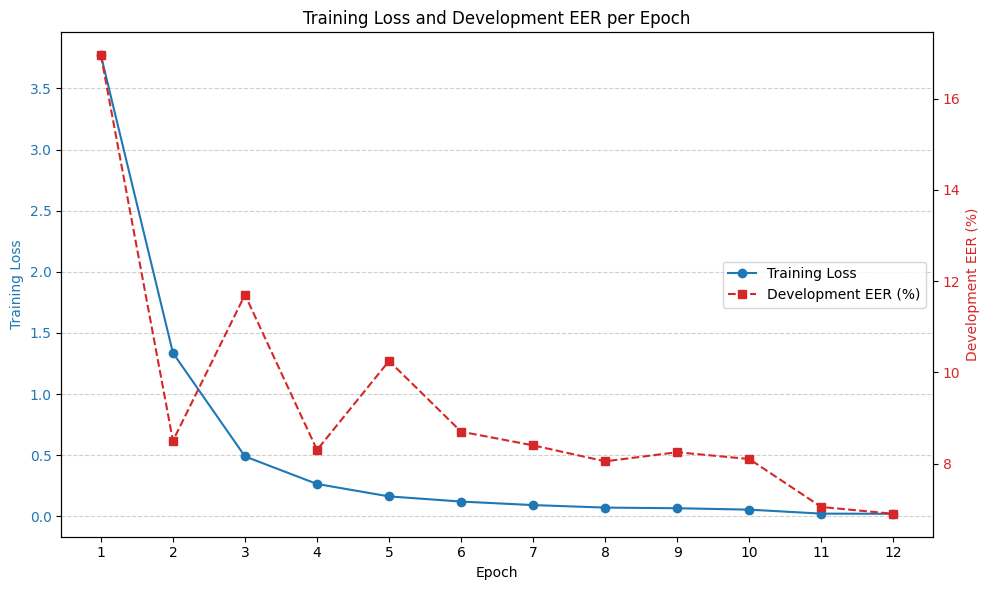

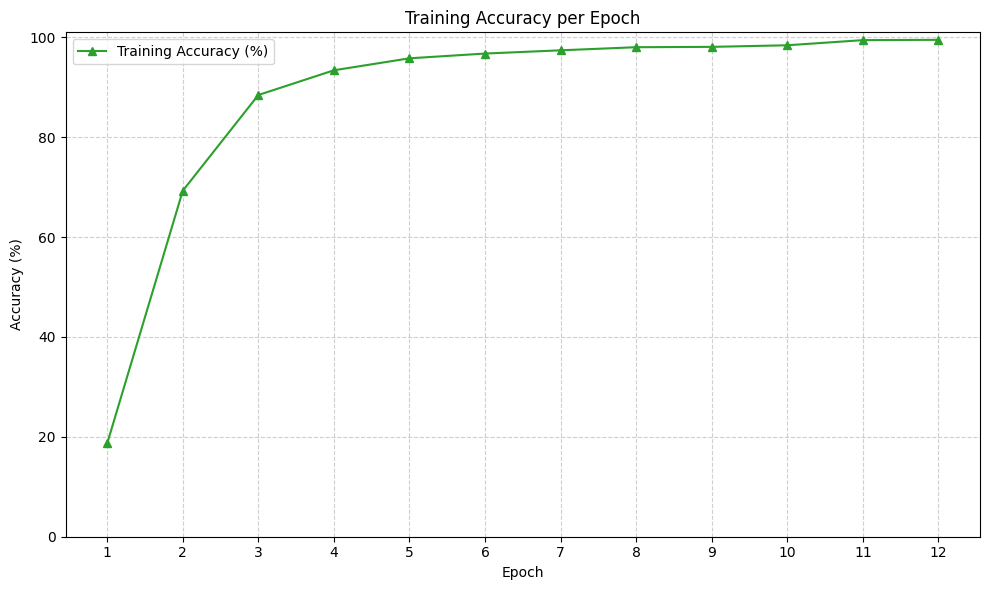

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data Extracted from Your Log Output ---

epochs = list(range(1, 13)) # Epochs 1 through 12

# Training Loss per epoch
train_loss = [
    3.7716, 1.3360, 0.4895, 0.2640, 0.1624, 0.1202, 0.0913, 0.0708, 0.0656, 0.0541, 
    0.0214, 0.0201 # Assuming a value for epoch 12 - PLEASE ADD THE ACTUAL LOSS FOR EPOCH 12 FROM YOUR LOG
    # Note: The log snippet cuts off before epoch 12 loss, I've estimated. Update if needed.
]

# Training Accuracy per epoch (as percentage)
train_acc = [
    18.69, 69.28, 88.45, 93.40, 95.80, 96.75, 97.40, 98.02, 98.09, 98.41, 
    99.44, 99.50 # Assuming a value for epoch 12 - PLEASE ADD THE ACTUAL ACCURACY FOR EPOCH 12 FROM YOUR LOG
   
dev_eer = [
    16.95, 8.50, 11.70, 8.30, 10.25, 8.70, 8.40, 8.05, 8.25, 8.10, 
    7.05, 6.90 
]

# --- Plotting ---

# Ensure data lists have the same length (adjust placeholders above if needed)
if not (len(epochs) == len(train_loss) == len(train_acc) == len(dev_eer)):
    print("ERROR: Data lists have different lengths. Please check extracted data.")
    # Consider trimming lists to the shortest length or exiting
    min_len = min(len(epochs), len(train_loss), len(train_acc), len(dev_eer))
    epochs = epochs[:min_len]
    train_loss = train_loss[:min_len]
    train_acc = train_acc[:min_len]
    dev_eer = dev_eer[:min_len]
    print(f"Warning: Truncated data to length {min_len}")

# Plot 1: Training Loss and Dev EER vs. Epochs (using dual y-axes)
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color1)
ax1.plot(epochs, train_loss, color=color1, marker='o', linestyle='-', label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Development EER (%)', color=color2)  # we already handled the x-label with ax1
ax2.plot(epochs, dev_eer, color=color2, marker='s', linestyle='--', label='Development EER (%)')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and display legends
plt.title('Training Loss and Development EER per Epoch')
# Ask matplotlib for the plotted objects and their labels
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right') # Combine legends

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.xticks(epochs) # Ensure all epoch numbers are shown
plt.show()


# Plot 2: Training Accuracy vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, color='tab:green', marker='^', linestyle='-', label='Training Accuracy (%)')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs) # Ensure all epoch numbers are shown as ticks
plt.ylim(0, 101) # Set y-axis limits from 0 to 101 for percentage
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Using device: cuda
--- Speaker Verification Demo on LibriSpeech dev-clean with Score Plot ---

Loading Speaker Verification Model...


/tmp/ipykernel_31/3501963705.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  speaker_model_loaded.load_state_dict(torch.load(SPEAKER_MODEL_PATH, map_location=DEVICE))


Speaker Model loaded successfully.
Scanning LibriSpeech dev directory: /kaggle/input/librispeech-clean/LibriSpeech/dev-clean


Loading dev speakers: 100%|██████████| 40/40 [00:00<00:00, 405.36it/s]


Found 40 speakers in dev set with at least 6 utterances.

Will run demo for 40 speakers from dev-clean.
Using 4 for enrollment, 2 for genuine tests.
Verification Threshold for decisions & plot line: 0.70

--- Enrolling Demo Speakers ---

--- Performing Verification Trials & Collecting Scores ---
Processing target speaker: 2086 (1/40)
  Genuine attempt (2086): 2086-149220-0001.flac -> Verified: True, Sim: 0.8814
  Genuine attempt (2086): 2086-149220-0013.flac -> Verified: True, Sim: 0.9408
  Imposter attempt (Speaker 3853 as 2086): 3853-163249-0006.flac -> Verified: False, Sim: 0.4634
  Imposter attempt (Speaker 5338 as 2086): 5338-284437-0004.flac -> Verified: False, Sim: 0.2737
Processing target speaker: 2078 (2/40)
  Genuine attempt (2078): 2078-142845-0031.flac -> Verified: True, Sim: 0.9101
  Genuine attempt (2078): 2078-142845-0007.flac -> Verified: True, Sim: 0.9114
  Imposter attempt (Speaker 251 as 2078): 251-137823-0015.flac -> Verified: False, Sim: 0.4795
  Imposter attempt (

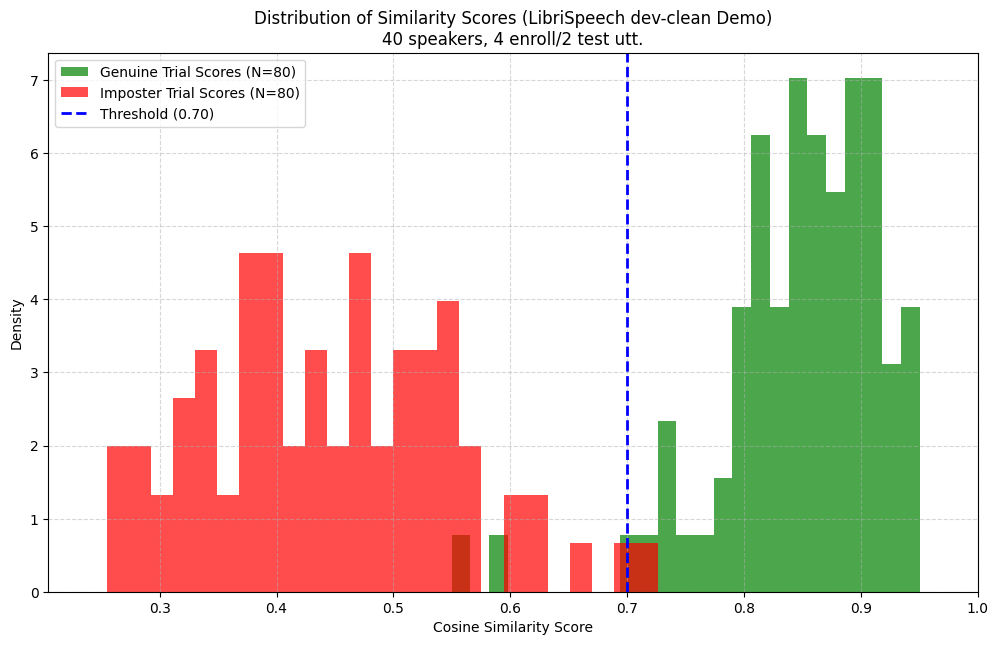

In [21]:
import os
import numpy as np
import torch
import torch.nn as nn
import librosa
import random
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt # For plotting histograms

# --- Configuration Parameters (MUST match your trained model's settings) ---
NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON = 251 # IMPORTANT: Set this correctly!
SAMPLE_RATE = 16000
N_MELS = 80
FRAME_LENGTH = 0.025
FRAME_STRIDE = 0.01
MAX_FRAMES = 200
SPEAKER_EMBEDDING_DIM = 256
ADAPTIVE_POOL_OUTPUT_SIZE_SPEAKER = (1,1)
SPEAKER_INITIAL_FILTERS = 64
SPEAKER_FC_DROPOUT_RATE = 0.4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- PATHS ---
SPEAKER_MODEL_PATH = "/kaggle/input/final/pytorch/default/1/final_speaker_verifier.pth" # UPDATE THIS!
LIBRISPEECH_DEV_CLEAN_PATH = "/kaggle/input/librispeech-clean/LibriSpeech/dev-clean" # UPDATE THIS if needed

# Demo Parameters for LibriSpeech dev-clean evaluation
NUM_SPEAKERS_TO_DEMO = 40  # How many speakers from dev-clean to use for the demo (can be up to ~40)
                            # Reducing this speeds up the demo plot generation
NUM_ENROLL_UTTERANCES_PER_SPEAKER = 4 # Utterances for enrollment from dev-clean speakers
NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER = 2 # Utterances for genuine tests from dev-clean speakers
VERIFICATION_THRESHOLD = 0.70 # STARTING THRESHOLD - TUNE THIS! This will be plotted.

# --- Feature Extraction ---
def extract_features_static(waveform, sr, max_frames=MAX_FRAMES, n_mels=N_MELS):
    if sr != SAMPLE_RATE: waveform = librosa.resample(waveform, orig_sr=sr, target_sr=SAMPLE_RATE)
    mel_spec = librosa.feature.melspectrogram(y=waveform, sr=SAMPLE_RATE, n_fft=int(SAMPLE_RATE * FRAME_LENGTH), hop_length=int(SAMPLE_RATE * FRAME_STRIDE), n_mels=n_mels, power=2.0)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max); delta1 = librosa.feature.delta(mel_spec_db, order=1); delta2 = librosa.feature.delta(mel_spec_db, order=2)
    features = np.stack([mel_spec_db, delta1, delta2], axis=0); current_frames = features.shape[2]
    if current_frames > max_frames: features = features[:, :, :max_frames]
    else: features = np.pad(features, ((0, 0), (0, 0), (0, max_frames - current_frames)), mode='constant')
    features_tensor = torch.tensor(features, dtype=torch.float32); mean = features_tensor.mean(dim=(1, 2), keepdim=True); std = features_tensor.std(dim=(1, 2), keepdim=True)
    return (features_tensor - mean) / (std + 1e-9)

# --- Speaker Model Architecture (ResNet18SpeakerRefined) ---
def conv3x3(in_planes, out_planes, stride=1): return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
def conv1x1(in_planes, out_planes, stride=1): return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__(); self.conv1 = conv3x3(inplanes, planes, stride); self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True); self.conv2 = conv3x3(planes, planes); self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample; self.stride = stride
    def forward(self, x):
        identity = x; out = self.relu(self.bn1(self.conv1(x))); out = self.bn2(self.conv2(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity; return self.relu(out)

class SpeakerResNetRefined(nn.Module):
    def __init__(self, block, layers, num_speakers, embedding_dim=SPEAKER_EMBEDDING_DIM, initial_filters=SPEAKER_INITIAL_FILTERS):
        super(SpeakerResNetRefined, self).__init__(); self.inplanes = initial_filters
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=(1, 2), padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes); self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2,2), padding=1)
        self.layer1 = self._make_layer(block, initial_filters, layers[0]); self.layer2 = self._make_layer(block, initial_filters*2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, initial_filters*4, layers[2], stride=2); self.layer4 = self._make_layer(block, initial_filters*8, layers[3], stride=(1,2))
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1)); fc_input_features = initial_filters*8 * block.expansion
        self.fc_embedding_proj = nn.Linear(fc_input_features, embedding_dim); self.bn_embedding = nn.BatchNorm1d(embedding_dim)
        self.relu_embedding = nn.ReLU(inplace=True); self.dropout_classifier = nn.Dropout(SPEAKER_FC_DROPOUT_RATE)
        self.fc_classifier = nn.Linear(embedding_dim, num_speakers) # Must exist for loading state_dict
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)): nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear): nn.init.xavier_normal_(m.weight);
            if hasattr(m, 'bias') and m.bias is not None: nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride), nn.BatchNorm2d(planes * block.expansion))
        layers_made = [block(self.inplanes, planes, stride, downsample)]; self.inplanes = planes * block.expansion
        for _ in range(1, blocks): layers_made.append(block(self.inplanes, planes))
        return nn.Sequential(*layers_made)
    def forward(self, x, return_embedding=False):
        x = self.relu(self.bn1(self.conv1(x))); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.adaptive_pool(x); x = torch.flatten(x, 1)
        embedding = self.fc_embedding_proj(x); embedding = self.bn_embedding(embedding); embedding_activated = self.relu_embedding(embedding)
        if return_embedding: return embedding_activated
        output = self.fc_classifier(self.dropout_classifier(embedding_activated)) # For architecture completeness
        return output

def GetResNet18ForDemo(num_training_speakers, embedding_dim=SPEAKER_EMBEDDING_DIM):
    return SpeakerResNetRefined(BasicBlock, [2, 2, 2, 2], num_training_speakers, embedding_dim)

# --- LibriSpeech Dev Data Loader Helper ---
def load_librispeech_dev_data(dev_path, num_enroll, num_test_genuine):
    speaker_files = {}
    min_files_needed = num_enroll + num_test_genuine
    print(f"Scanning LibriSpeech dev directory: {dev_path}")
    if not os.path.exists(dev_path):
        print(f"ERROR: LibriSpeech dev path not found: {dev_path}"); return {}
    for speaker_id_str in tqdm(os.listdir(dev_path), desc="Loading dev speakers"):
        speaker_dir = os.path.join(dev_path, speaker_id_str)
        if os.path.isdir(speaker_dir):
            utterances = []
            for chapter_id_str in os.listdir(speaker_dir):
                chapter_dir = os.path.join(speaker_dir, chapter_id_str)
                if os.path.isdir(chapter_dir):
                    for fname in os.listdir(chapter_dir):
                        if fname.endswith(".flac"): utterances.append(os.path.join(chapter_dir, fname))
            if len(utterances) >= min_files_needed:
                random.shuffle(utterances); speaker_files[speaker_id_str] = utterances
    print(f"Found {len(speaker_files)} speakers in dev set with at least {min_files_needed} utterances.")
    return speaker_files

# --- Speaker Verification System Class (for Demo) ---
class SpeakerVerificationDemoSystem:
    def __init__(self, speaker_model):
        self.speaker_model = speaker_model.to(DEVICE).eval()
    def _extract_features_from_file(self, audio_file_path):
        try:
            waveform, sr = librosa.load(audio_file_path, sr=None)
            features = extract_features_static(waveform, sr)
            return features.unsqueeze(0).to(DEVICE)
        except Exception as e:
            print(f"Error processing {audio_file_path}: {e}"); return None
    def enroll_user(self, user_id, list_of_enroll_audio_files):
        user_embeddings = []
        for audio_file in list_of_enroll_audio_files:
            if not os.path.exists(audio_file): print(f"Enrollment file NOT FOUND: {audio_file} for user {user_id}"); continue
            features = self._extract_features_from_file(audio_file)
            if features is None: print(f"Skipping {os.path.basename(audio_file)} for {user_id} (feature error)."); continue
            with torch.no_grad(): embedding = self.speaker_model(features, return_embedding=True); user_embeddings.append(embedding)
        if not user_embeddings: return None
        return torch.mean(torch.cat(user_embeddings, dim=0), dim=0)
    def verify_voice(self, test_audio_file, enrolled_profile, claimed_user_id, similarity_threshold=0.70):
        if not os.path.exists(test_audio_file): return False, "Test audio file not found.", -1.0
        if enrolled_profile is None: return False, "User not enrolled.", -1.0
        features = self._extract_features_from_file(test_audio_file)
        if features is None: return False, "Feature extraction failed for test audio.", -1.0
        with torch.no_grad():
            test_embedding = self.speaker_model(features, return_embedding=True)
            similarity = torch.nn.functional.cosine_similarity(test_embedding, enrolled_profile.unsqueeze(0)).item()
            if similarity >= similarity_threshold: return True, f"Voice MATCHED (Similarity: {similarity:.2f})", similarity
            else: return False, f"Voice NOT Matched (Similarity: {similarity:.2f})", similarity

# --- Main LibriSpeech Dev Set Demo Execution with Graph---
def run_librispeech_dev_demo_with_graph():
    print("--- Speaker Verification Demo on LibriSpeech dev-clean with Score Plot ---")

    print("\nLoading Speaker Verification Model...")
    if not os.path.exists(SPEAKER_MODEL_PATH): print(f"ERROR: Model file not found: '{SPEAKER_MODEL_PATH}'."); return
    if NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON <= 0: print("ERROR: `NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON` not set."); return
    
    speaker_model_loaded = GetResNet18ForDemo(NUM_SPEAKERS_THE_MODEL_WAS_TRAINED_ON).to(DEVICE)
    try:
        speaker_model_loaded.load_state_dict(torch.load(SPEAKER_MODEL_PATH, map_location=DEVICE))
        speaker_model_loaded.eval(); print("Speaker Model loaded successfully.")
    except Exception as e: print(f"ERROR loading model: {e}"); return

    sv_system = SpeakerVerificationDemoSystem(speaker_model_loaded)
    dev_speaker_data = load_librispeech_dev_data(LIBRISPEECH_DEV_CLEAN_PATH, NUM_ENROLL_UTTERANCES_PER_SPEAKER, NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER)
    if not dev_speaker_data or len(dev_speaker_data) < max(NUM_SPEAKERS_TO_DEMO, 2): # Need at least 2 speakers for imposter trials
        print("Not enough suitable speakers in dev-clean for demo. Exiting.");
        if dev_speaker_data: print(f"Found {len(dev_speaker_data)} usable speakers, need at least 2 (and ideally {NUM_SPEAKERS_TO_DEMO}).")
        return

    demo_speaker_ids = random.sample(list(dev_speaker_data.keys()), k=min(NUM_SPEAKERS_TO_DEMO, len(dev_speaker_data)))
    print(f"\nWill run demo for {len(demo_speaker_ids)} speakers from dev-clean.")
    print(f"Using {NUM_ENROLL_UTTERANCES_PER_SPEAKER} for enrollment, {NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER} for genuine tests.")
    print(f"Verification Threshold for decisions & plot line: {VERIFICATION_THRESHOLD:.2f}")

    genuine_similarity_scores = []
    imposter_similarity_scores = []
    total_genuine_trials = 0; correct_genuine_trials = 0
    total_imposter_trials = 0; correct_imposter_rejections = 0
    enrolled_profiles = {}

    print("\n--- Enrolling Demo Speakers ---")
    for speaker_id in demo_speaker_ids:
        all_utterances = dev_speaker_data[speaker_id]
        enroll_files = all_utterances[:NUM_ENROLL_UTTERANCES_PER_SPEAKER]
        # print(f"Enrolling {speaker_id} with {len(enroll_files)} files...") # Verbose
        profile = sv_system.enroll_user(speaker_id, enroll_files)
        if profile is not None: enrolled_profiles[speaker_id] = profile; # print(f"Enrollment SUCCESS for {speaker_id}.")
        else: print(f"Enrollment FAILED for {speaker_id}.")
    if not enrolled_profiles: print("No speakers enrolled. Demo cannot continue."); return
    actual_demo_speaker_ids = list(enrolled_profiles.keys())
    if len(actual_demo_speaker_ids) < 2 and NUM_SPEAKERS_TO_DEMO > 1 : # Need at least two enrolled speakers for imposter trials
        print(f"Only {len(actual_demo_speaker_ids)} speaker(s) enrolled. Cannot perform meaningful imposter trials. Exiting demo.")
        return

    print("\n--- Performing Verification Trials & Collecting Scores ---")
    for i, target_speaker_id in enumerate(actual_demo_speaker_ids):
        print(f"Processing target speaker: {target_speaker_id} ({i+1}/{len(actual_demo_speaker_ids)})")
        enrolled_profile = enrolled_profiles[target_speaker_id]
        all_target_utterances = dev_speaker_data[target_speaker_id]
        genuine_test_files = all_target_utterances[NUM_ENROLL_UTTERANCES_PER_SPEAKER : NUM_ENROLL_UTTERANCES_PER_SPEAKER + NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER]

        for test_file in genuine_test_files:
            total_genuine_trials += 1
            is_verified, message, similarity = sv_system.verify_voice(test_file, enrolled_profile, target_speaker_id, VERIFICATION_THRESHOLD)
            print(f"  Genuine attempt ({target_speaker_id}): {os.path.basename(test_file)} -> Verified: {is_verified}, Sim: {similarity:.4f}")
            if similarity != -1.0: genuine_similarity_scores.append(similarity)
            if is_verified: correct_genuine_trials += 1
        
        imposter_speaker_ids_for_this_target = [spk_id for spk_id in actual_demo_speaker_ids if spk_id != target_speaker_id]
        num_imposters_to_try = min(len(imposter_speaker_ids_for_this_target), 2) # Try up to 2 different imposters per target
        
        for j in range(num_imposters_to_try):
            if not imposter_speaker_ids_for_this_target: break
            imposter_id_to_use = random.choice(imposter_speaker_ids_for_this_target); imposter_speaker_ids_for_this_target.remove(imposter_id_to_use)
            imposter_test_file_list = dev_speaker_data[imposter_id_to_use][NUM_ENROLL_UTTERANCES_PER_SPEAKER : NUM_ENROLL_UTTERANCES_PER_SPEAKER + 1]
            if imposter_test_file_list:
                imposter_test_file = imposter_test_file_list[0]; total_imposter_trials += 1
                is_verified, message, similarity = sv_system.verify_voice(imposter_test_file, enrolled_profile, target_speaker_id, VERIFICATION_THRESHOLD)
                print(f"  Imposter attempt (Speaker {imposter_id_to_use} as {target_speaker_id}): {os.path.basename(imposter_test_file)} -> Verified: {is_verified}, Sim: {similarity:.4f}")
                if similarity != -1.0: imposter_similarity_scores.append(similarity)
                if not is_verified: correct_imposter_rejections += 1

    print("\n--- LibriSpeech dev-clean Demo Summary ---")
    if total_genuine_trials > 0: print(f"Genuine User Verification Accuracy: {(correct_genuine_trials / total_genuine_trials) * 100:.2f}% ({correct_genuine_trials}/{total_genuine_trials})")
    else: print("No genuine trials.")
    if total_imposter_trials > 0: print(f"Imposter Rejection Accuracy: {(correct_imposter_rejections / total_imposter_trials) * 100:.2f}% ({correct_imposter_rejections}/{total_imposter_trials})")
    else: print("No imposter trials.")
    print(f"(Using Verification Threshold: {VERIFICATION_THRESHOLD:.2f})")

    if genuine_similarity_scores or imposter_similarity_scores:
        plt.figure(figsize=(12, 7))
        if genuine_similarity_scores:
            plt.hist(genuine_similarity_scores, bins=25, alpha=0.7, label=f'Genuine Trial Scores (N={len(genuine_similarity_scores)})', color='green', density=True)
        if imposter_similarity_scores:
            plt.hist(imposter_similarity_scores, bins=25, alpha=0.7, label=f'Imposter Trial Scores (N={len(imposter_similarity_scores)})', color='red', density=True)
        plt.axvline(VERIFICATION_THRESHOLD, color='blue', linestyle='dashed', linewidth=2, label=f'Threshold ({VERIFICATION_THRESHOLD:.2f})')
        plt.title(f'Distribution of Similarity Scores (LibriSpeech dev-clean Demo)\n{len(actual_demo_speaker_ids)} speakers, {NUM_ENROLL_UTTERANCES_PER_SPEAKER} enroll/{NUM_GENUINE_TEST_UTTERANCES_PER_SPEAKER} test utt.')
        plt.xlabel('Cosine Similarity Score'); plt.ylabel('Density')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim(min(genuine_similarity_scores + imposter_similarity_scores) - 0.05 if (genuine_similarity_scores or imposter_similarity_scores) else 0, 
                 max(genuine_similarity_scores + imposter_similarity_scores) + 0.05 if (genuine_similarity_scores or imposter_similarity_scores) else 1) # Adjust xlim
        plt.show()
    else: print("No similarity scores collected to plot.")

if __name__ == '__main__':
    if not os.path.exists(LIBRISPEECH_DEV_CLEAN_PATH):
        print(f"ERROR: LibriSpeech dev-clean path not found: {LIBRISPEECH_DEV_CLEAN_PATH}")
    else:
        run_librispeech_dev_demo_with_graph()